In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats


In [3]:
############### Synthetic Data #############
# β = 0.005
# μ1 = 1/21 #14 days infectious
# μ2 = 1/5 #5 days (14 - 9 days)
# σ =1/5 #5 days exposed
# ω=1/9 # 9 days until emitted to hospital
# ϵ = 0.0001
# # pp = 0.7
capT = 1000
# γ = 1/(80*365)
Input_H = [1500,0,1,0]
parameters = [Input_H, capT] 

In [2]:
def gillespieSEIR(initial, beta, mu1,mu2, sigma, epsilon,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]>0):
        state = np.zeros(shape= (4,4))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        rate = [R_se, R_ei, R_ir, R_is]

        Rtotal = sum(rate)
#         print(Rtotal)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
#         total_inf = sum(cuminf)
        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:3])
    return event_time, np.array(pop), events, cuminf

# Perform ABC on 2004 data

In [36]:
Data_F04=pd.read_csv("../Case_data/2004_F_cases.csv",sep = ',', header = 0)
############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days) 
    record = [int(a - record[0]) for a in record]
    return record

Rec_F04=Spacing(Data_F04)
summary = np.array([Rec_F04, Data_F04['CumsumInf'].values])

In [61]:
N = 50
tol = 70
t = 0 
θ = []

β1, ɛ1, σ1, μ11,μ21 =  [np.random.uniform(0,0.1, N), np.random.uniform(0,0.001, N),
                     1/np.random.uniform(1,30, N), 1/np.random.uniform(1, 40, N),
                     1/np.random.uniform(1,40, N)]
#     print(np.array([β1, ɛ1, p1 ]))

θ = [np.array([β1, ɛ1, σ1, μ11, μ21]).T]
# print(θ[0][:,0])
t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1)
    r_ϵ = np.random.randint(0,N-1)
    r_σ= np.random.randint(0,N-1)
    r_μ1 = np.random.randint(0,N-1)
    r_μ2 = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt, σt, μ1t, μ2t = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_σ] + δ, θ[t-1][:,3][r_μ1] +δ, θ[t-1][:,4][r_μ2] +δ

    M =gillespieSEIR(parameters[0], βt, μ1t,μ2t,σt,ɛt,  parameters[1])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = summary[0]
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = summary[1]
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 3)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    
#         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]), βt, ɛt, pt)
    if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
        θ_t.append(np.array([βt, ɛt, σt, μ1t, μ2t]))
        print(len(θ_t), t, tol, np.linalg.norm(summary_cum-inter_cum[summary_time]))
#             θ_t = np.array(θ_t)
#             print(θ_t)
        error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
    if len(θ_t) == N:
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
        print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

1 1 70 51.35172830587107
2 1 70 51.57518783291051
3 1 70 56.542019772908716
4 1 70 41.20679555607303
5 1 70 49.1121166312347
6 1 70 60.27437266367855
7 1 70 64.79197481170026
8 1 70 60.876925020897694
9 1 70 46.52956049652737
10 1 70 54.26785420486054
11 1 70 43.726422218150894
12 1 70 19.672315572906
13 1 70 41.20679555607303
14 1 70 52.94336596779619
15 1 70 53.08483775994799
16 1 70 49.57822102496216
17 1 70 68.28616258071617
18 1 70 56.7626637852735
19 1 70 55.82114294781145
20 1 70 53.03772242470448
21 1 70 50.76416058598822
22 1 70 57.07889277132134
23 1 70 57.7148161220323
24 1 70 57.784080852774665
25 1 70 65.62011886609167
26 1 70 52.848841046895245
27 1 70 32.01562118716424
28 1 70 63.14269553954757
29 1 70 57.73214009544424
30 1 70 56.356011214421486
31 1 70 51.05878964487897
32 1 70 47.634021455258214
33 1 70 38.353617821530214
34 1 70 65.43699259593154
35 1 70 54.42425929675111
36 1 70 35.93048844644336
37 1 70 44.75488800120049
38 1 70 47.97916214358062
39 1 70 67.8675180

1 3 48.0934968129053 47.18050444834179
2 3 48.0934968129053 46.08687448721165
3 3 48.0934968129053 44.96665431183423
4 3 48.0934968129053 47.34976240700686
5 3 48.0934968129053 25.592967784139454
6 3 48.0934968129053 39.230090491866065
7 3 48.0934968129053 46.74398357008097
8 3 48.0934968129053 29.5296461204668
9 3 48.0934968129053 46.24932431938871
10 3 48.0934968129053 44.68780594300866
11 3 48.0934968129053 48.08326112068523
12 3 48.0934968129053 47.19110085598767
13 3 48.0934968129053 28.930952282978865
14 3 48.0934968129053 46.76537180435969
15 3 48.0934968129053 47.54997371187496
16 3 48.0934968129053 43.669211121796096
17 3 48.0934968129053 46.636895265444075
18 3 48.0934968129053 41.7612260356422
19 3 48.0934968129053 34.583232931581165
20 3 48.0934968129053 37.8021163428716
21 3 48.0934968129053 30.44667469527666
22 3 48.0934968129053 39.42080668885405
23 3 48.0934968129053 44.48595283907045
24 3 48.0934968129053 46.58325879540846
25 3 48.0934968129053 45.70557952810576
26 3 4

1 5 38.316999314076014 29.086079144497972
2 5 38.316999314076014 37.61648574760805
3 5 38.316999314076014 37.94733192202055
4 5 38.316999314076014 32.41913015489465
5 5 38.316999314076014 35.397740040855716
6 5 38.316999314076014 35.45419580247167
7 5 38.316999314076014 34.11744421846396
8 5 38.316999314076014 36.235341863986875
9 5 38.316999314076014 31.32091952673165
10 5 38.316999314076014 36.207733980463345
11 5 38.316999314076014 25.67099530598687
12 5 38.316999314076014 31.591137997862628
13 5 38.316999314076014 37.20215047547655
14 5 38.316999314076014 25.495097567963924
15 5 38.316999314076014 32.109188716004645
16 5 38.316999314076014 33.04542328371661
17 5 38.316999314076014 37.094473981982816
18 5 38.316999314076014 37.22902093797257
19 5 38.316999314076014 28.337254630609507
20 5 38.316999314076014 31.78049716414141
21 5 38.316999314076014 28.53068523537421
22 5 38.316999314076014 36.945906403822335
23 5 38.316999314076014 32.49615361854384
24 5 38.316999314076014 27.928480

In [66]:
np.save('theta_SEIR_2', θ)
np.save('tols_SEIR_2', tols)

In [73]:
# np.save('theta_SEIR', θ)
# np.save('tols_SEIR', tols)
len(θ[0][:,1])

50

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


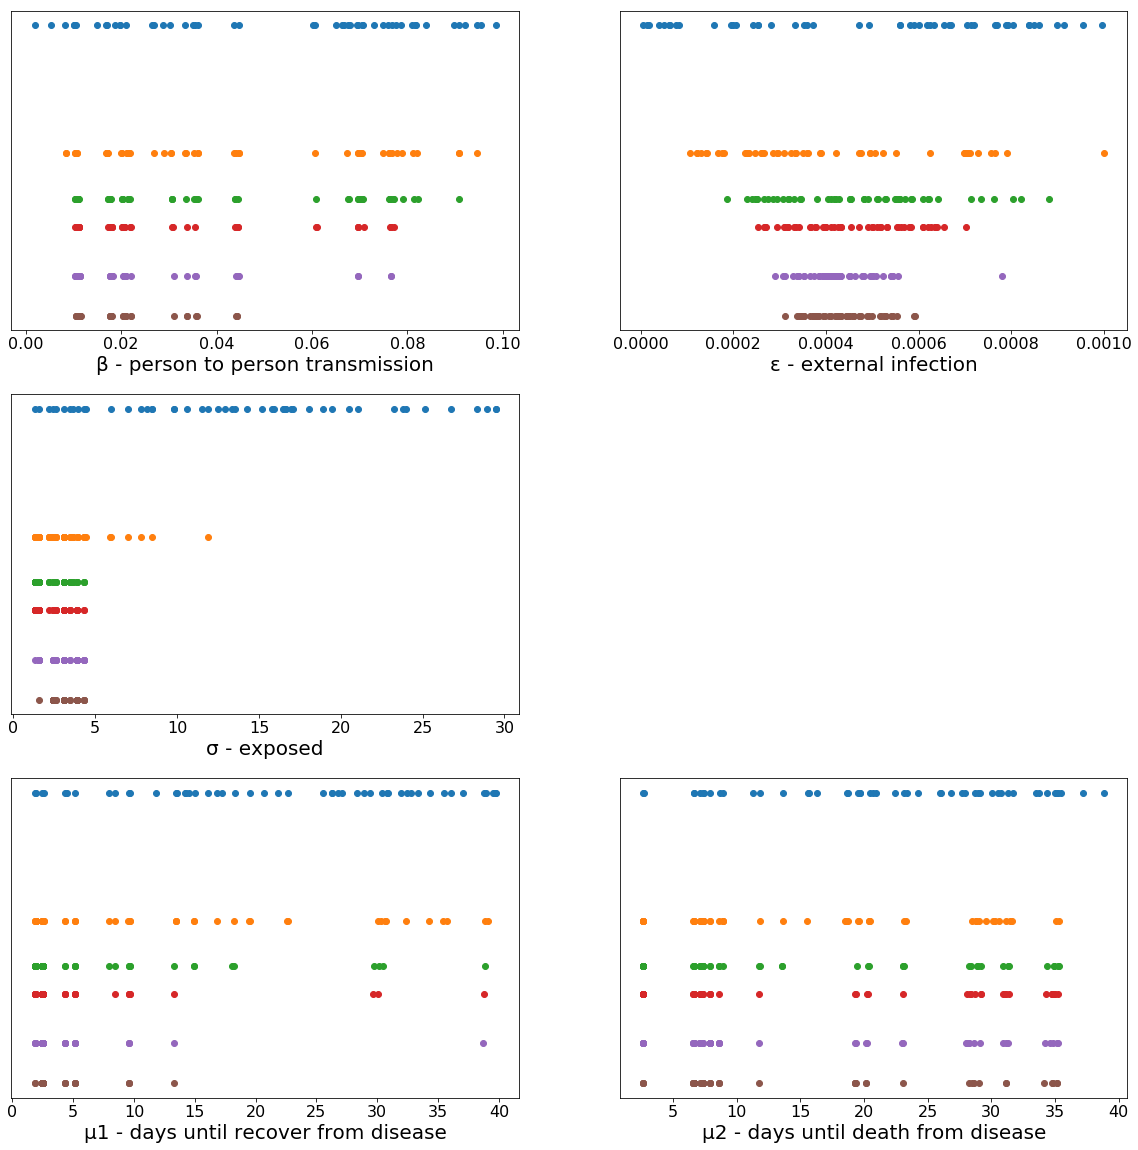

In [67]:
plt.figure(figsize = (20,20))
tol = 6
for i in range(6):
    plt.subplot(3,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(3,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,3)
    plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
    plt.xlabel('σ - exposed', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,5)
    plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
    plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,6)
    plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
    plt.xlabel('μ2 - days until death from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)
    
#     tol -=1

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 9 Text xticklabel objects>)

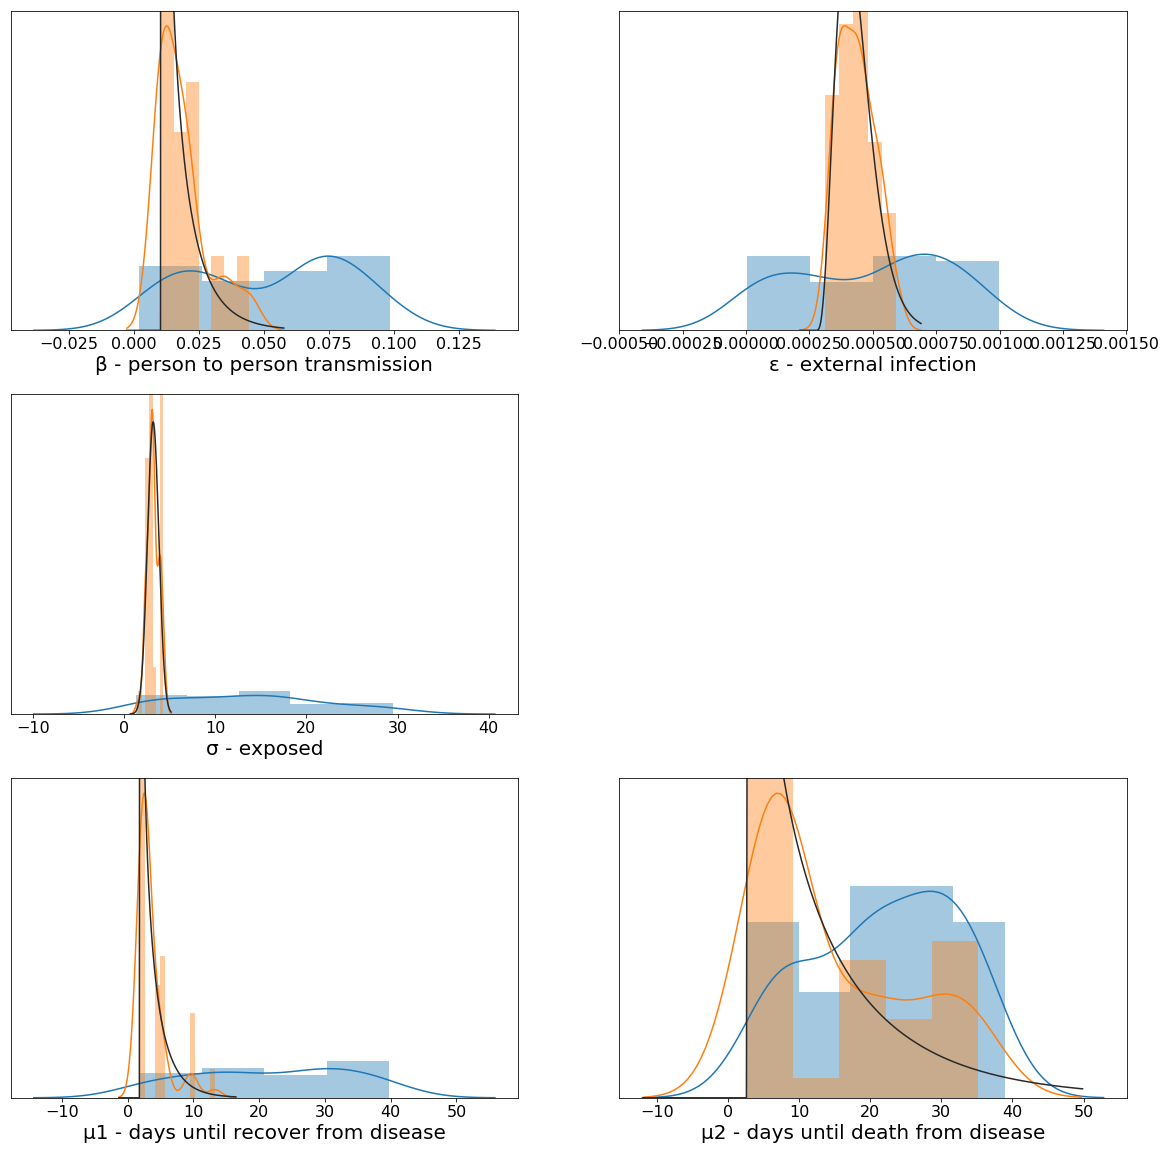

In [68]:
plt.figure(figsize = (20,20))

plt.subplot(3,2,1)
#     plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('β - person to person transmission', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,2)
#     plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,1],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,1],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('ɛ - external infection', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,3)
#     plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,2]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,2]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('σ - exposed', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,5)
sns.distplot([1/a for a in θ[0][:,3]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,3]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

plt.subplot(3,2,6)
#     plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,4]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,4]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('μ2 - days until death from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

In [52]:
θ[0][:,4]

array([0.52822625, 0.86637948, 0.28500034, 0.06135147, 0.9182659 ,
       0.92654966, 0.04514459, 0.80522777, 0.17100019, 0.0764408 ,
       0.36729449, 0.45423968, 0.3058543 , 0.65257492, 0.93675034,
       0.45078813, 0.7637251 , 0.97131353, 0.97980169, 0.39898313,
       0.29628613, 0.06936889, 0.47408146, 0.29606696, 0.79690187,
       0.55403808, 0.90322382, 0.92146788, 0.80602897, 0.09072137,
       0.43915395, 0.76673742, 0.81034834, 0.07485401, 0.27359645,
       0.86017181, 0.51692963, 0.13481701, 0.91586045, 0.81496387,
       0.29893272, 0.6548416 , 0.07318213, 0.06385826, 0.18247037,
       0.73126591, 0.61023635, 0.14597131, 0.49646906, 0.62153419])

In [59]:
1/np.random.uniform(1/40, 1, N)

array([ 3.740377  ,  2.56530302,  1.36077233,  2.50502548,  1.35563943,
        6.41222227,  1.10128274,  3.84976898,  8.45116863,  1.46735116,
        2.58896475,  2.88171779,  1.1849022 ,  1.95813764,  1.32798815,
        6.02341893,  4.39494645,  1.17686278,  3.91898067, 13.35922364,
        1.88421647,  1.6276429 ,  2.7838824 ,  1.64710781,  2.60298065,
        1.00460178,  1.12868546,  2.30961342,  1.13812756,  4.1738083 ,
       24.89660481,  1.96949514,  1.22695429,  1.20720685,  1.72214373,
        1.61735294,  1.55966241,  1.13839874,  1.31270731,  2.0823517 ,
        1.83226458,  1.71480371, 17.98652036,  1.26915015,  1.15157415,
        1.97466364,  1.87127419,  2.0458624 ,  1.28431248,  1.61419192])

In [82]:
mu = 1/(71*365)
beta, epsilon, sigma, mu1, mu2 = np.mean(θ[5], axis = 0)

In [87]:
r0 = (beta*sigma)/((sigma+mu)*(mu1 + mu2 + mu))
r0

0.03928913671533581